In [1]:
import os
import numpy as np
import warnings
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from pycocotools.coco import COCO
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import cv2
import json
from panopticapi.utils import rgb2id

BATCH_SIZE = 8
IMG_WIDTH = 128
IMG_HEIGHT = 128

TRAIN_PATH = './COCO/'
TEST_PATH = './COCO/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

In [2]:
class COCOSegmentationDataset(Dataset):
    def __init__(self, panoptic_json, panoptic_root, img_dir, transforms=None, img_size=(128, 128)):
        self.img_dir = img_dir
        self.panoptic_root = panoptic_root
        self.transforms = transforms
        self.img_width, self.img_height = img_size
        
        with open(panoptic_json, 'r') as f: #Processing Panoptic Data
            self.panoptic_data = json.load(f) #Reads and loads the panoptic JSON file into self.panoptic_data

        self.images = self.panoptic_data["images"] #Extract the list of images from the JSON metadata

        self.annotations = {} 
        for ann in self.panoptic_data["annotations"]: #Stores annotations in a dictionary where keys are images ID,
            self.annotations[ann["image_id"]] = ann 

        self.categories = self.panoptic_data["categories"]#Extract Category info and assign unique label; index to each ID

        all_cat_ids = sorted(cat["id"] for cat in self.categories)
        self.cat2label = {cat_id: idx for idx, cat_id in enumerate(all_cat_ids)}

    def __len__(self): #Returns the number of images in the dataset.
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx] #Below are for some basic info of the images
        image_id = img_info["id"]
        w, h = img_info["width"], img_info["height"]
        img_filename = img_info["file_name"]  

        img_path = os.path.join(self.img_dir, img_filename) #image path
        image_bgr = cv2.imread(img_path) #loading
        if image_bgr is None: #Error Handling
            raise FileNotFoundError(f"Could not find {img_path}")
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)#Color Converstion to RGB

        #Loading Segmentation Mask
        ann_info = self.annotations[image_id] #
        seg_filename = ann_info["file_name"]  
        seg_path = os.path.join(self.panoptic_root, seg_filename)
        seg_bgr = cv2.imread(seg_path, cv2.IMREAD_COLOR) #loads the Seg mask into BGR
        if seg_bgr is None:
            raise FileNotFoundError(f"Could not find {seg_path}")

        seg_rgb = cv2.cvtColor(seg_bgr, cv2.COLOR_BGR2RGB)
        seg_id_map = rgb2id(seg_rgb)  

        semantic_mask = np.zeros((h, w), dtype=np.int32)

        for seg in ann_info["segments_info"]:
            cat_id = seg["category_id"]  
            seg_id = seg["id"]          

            label_id = self.cat2label[cat_id]

            mask_pixels = (seg_id_map == seg_id)
            semantic_mask[mask_pixels] = label_id

        image_rgb = cv2.resize(image_rgb, (self.img_width, self.img_height), interpolation=cv2.INTER_LINEAR)
        semantic_mask = cv2.resize(semantic_mask, (self.img_width, self.img_height), interpolation=cv2.INTER_NEAREST)

        if self.transforms:
            image_rgb = self.transforms(image_rgb)  

        semantic_mask = torch.from_numpy(semantic_mask).long()

        return image_rgb, semantic_mask

In [3]:
train_dataset = COCOSegmentationDataset(
    panoptic_json=os.path.join(TRAIN_PATH, 'annotations', 'panoptic_train_subset.json'),
    panoptic_root=os.path.join(TRAIN_PATH, 'panoptic_train_subset'), 
    img_dir=os.path.join(TRAIN_PATH, 'train_subset'),
    transforms=ToTensor(),
    img_size=(IMG_HEIGHT, IMG_WIDTH)
)
val_dataset = COCOSegmentationDataset(
    panoptic_json=os.path.join(TRAIN_PATH,  'annotations', 'panoptic_val2017.json'),
    panoptic_root=os.path.join(TRAIN_PATH, 'panoptic_val2017'), 
    img_dir=os.path.join(TRAIN_PATH, 'val2017'),
    transforms=ToTensor(),
    img_size=(IMG_HEIGHT, IMG_WIDTH)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [4]:
import random
import matplotlib.pyplot as plt
import numpy as np

def visualize_random_sample(dataset):
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]
    if isinstance(image, torch.Tensor):
        # Permute to [H, W, C]
        image_np = image.permute(1, 2, 0).cpu().numpy()
        # If it's in range [0,1], scale for display:
        if image_np.max() <= 1.0:
            image_np = (image_np * 255).astype(np.uint8)
    else:
        # If 'image' is already a NumPy array with shape [H, W, C]
        image_np = image
        
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask.cpu().numpy() if isinstance(mask, torch.Tensor) else mask)
    plt.title("Mask")

    plt.show()


In [ ]:
visualize_random_sample(train_dataset)

In [5]:
def mean_iou(y_pred, y_true, num_classes, smooth=1e-6):
    
    y_pred = torch.softmax(y_pred/0.5, dim=1)
    y_pred = torch.argmax(y_pred, dim=1)

    iou_list = []

    for class_id in range(num_classes):
        intersection = torch.sum((y_pred == class_id) & (y_true == class_id))
        union = torch.sum((y_pred == class_id) | (y_true == class_id))
        
        if union == 0:
            continue 
        
        iou = (intersection.float() + smooth) / (union.float() + smooth)
        iou_list.append(iou)


    return torch.mean(torch.stack(iou_list))

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Mask2FormerAttention(nn.Module):
    def __init__(self, channels, size):
        super(Mask2FormerAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.query = nn.Linear(channels, channels)
        self.key = nn.Linear(channels, channels)
        self.value = nn.Linear(channels, channels)
        self.mask = None  
        self.norm = nn.LayerNorm([channels])

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        if channels != self.channels:
            raise ValueError("Input channel size does not match initialized channel size.")
        
        x = x.view(batch_size, channels, height * width).permute(0, 2, 1)  

        Q = self.query(x)  
        K = self.key(x)    
        V = self.value(x)  

        scores = torch.matmul(Q, K.transpose(-2, -1))  
        scores = scores / (self.channels ** 0.5)       

        if self.mask is None or self.mask.size(-1) != height * width:
            binary_mask = torch.randint(0, 2, (batch_size, height, width), device=x.device)
            binary_mask = binary_mask.view(batch_size, -1)  
            processed_mask = torch.where(binary_mask > 0.5, torch.tensor(0.0, device=x.device), torch.tensor(-float('inf'), device=x.device))
            self.mask = processed_mask.unsqueeze(1).expand(-1, height * width, -1) 
            
        scores = scores + self.mask

        attention_weights = F.softmax(scores, dim=-1)  
        attention_output = torch.matmul(attention_weights, V) 
        attention_output = attention_output + x  
        attention_output = self.norm(attention_output)
        
        return attention_output.view(batch_size, channels, height, width)


In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super(ConvBlock, self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.conv_block(x))
        else:
            return self.conv_block(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(DownSample, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels),
            nn.BatchNorm2d(out_channels)
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        return x

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(UpSample, self).__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.out_channels = out_channels
        self.conv = nn.Sequential(
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels, in_channels // 2),
            nn.BatchNorm2d(out_channels)
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x):

        x = self.upsample(x)
        #print(x.shape)
        #print(skip_x.shape)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        #emb = self.emb_layer(t)[:, :, None, None].expand(-1, -1, x.shape[-2], x.shape[-1])
        return x
    
class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3):
        super(UNet, self).__init__()
        self.initial_conv = ConvBlock(c_in, 64)
        self.downsample1 = DownSample(64, 128)
        self.self_attention1 = Mask2FormerAttention(128, 128)
        self.downsample2 = DownSample(128, 256)
        self.self_attention2 = Mask2FormerAttention(256, 256)
        self.downsample3 = DownSample(256, 256)
        self.self_attention3 = Mask2FormerAttention(256, 256)

        self.bottom1 = ConvBlock(256, 512)
        self.bottom2 = ConvBlock(512, 512)
        self.bottom3 = ConvBlock(512, 256)
        
        self.dropout = nn.Dropout(0.3)
        
        self.upsample1 = UpSample(512, 128)
        self.self_attention4 = Mask2FormerAttention(128, 128)
        self.upsample2 = UpSample(256, 64)
        self.self_attention5 = Mask2FormerAttention(64, 64)
        self.upsample3 = UpSample(128, 64)
        self.self_attention6 = Mask2FormerAttention(64, 64)
        self.norm = nn.LayerNorm([64, 128, 128])
        # self.output_conv = nn.Conv2d(64, c_out, kernel_size=1)
        self.final_layer = nn.Sequential(
                                nn.Conv2d(64, c_out, kernel_size=1),
                                nn.BatchNorm2d(c_out), 
                                nn.ReLU()  
                            )

    def forward(self, x):

        x1 = self.initial_conv(x)
        x2 = self.downsample1(x1)
        x2 = self.self_attention1(x2)
        x3 = self.downsample2(x2)
        x3 = self.self_attention2(x3)
        x4 = self.downsample3(x3)
        x4 = self.self_attention3(x4)

        x4 = self.bottom1(x4)
        x4 = self.bottom2(x4)
        x4 = self.bottom3(x4)

        x = self.upsample1(x4, x3)
        x = self.dropout(x)
        x = self.self_attention4(x)
        x = self.upsample2(x, x2)
        x = self.dropout(x)
        x = self.self_attention5(x)
        x = self.upsample3(x, x1)
        x = self.self_attention6(x)
        x = self.norm(x)
        # output = self.output_conv(x)
        output = self.final_layer(x)
        return output


In [8]:
#define early stopping
class EarlyStopping:
    def __init__(self, patience=3, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, model):
        if self.verbose:
            print(f'Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pth')

In [ ]:
# from segmentation_models_pytorch import Unet

# pretrained_model = Unet(encoder_name="mit_b5", encoder_weights="imagenet",in_channels=3,classes=len(train_dataset.cat2label))
# pretrained_weights = pretrained_model.state_dict()

In [9]:
import torch.backends.cudnn as cudnn
# from torch_lr_finder import LRFinder

c_in = 3  # input channel 3 for RGB
c_out = len(train_dataset.cat2label)
print(f'total number of classes used: {c_out}')
if torch.cuda.device_count() > 1:
    device1 = torch.device("cuda:0")
    device2 = torch.device("cuda:1")
else:
    raise RuntimeError("Multiple GPUs are required.")

model = UNet(c_in, c_out)
checkpoint = torch.load('checkpoint.pth')
modified_state_dict = {key.replace('module.', ''): value for key, value in checkpoint.items()}
model.load_state_dict(modified_state_dict)

# def map_pretrained_to_check(pretrained_dict, custom_dict):
#     mapped_weights = {}
#     for key in pretrained_dict:
#         if key.startswith("encoder.conv1"):
#             new_key = key.replace("encoder.conv1", "initial_conv.conv_block.0")
#             if new_key in custom_dict:
#                 mapped_weights[new_key] = pretrained_dict[key]
#     return mapped_weights

# mapped_weights = map_pretrained_to_check(pretrained_weights, modified_state_dict)
# modified_state_dict.update(mapped_weights)
    
# model.load_state_dict(modified_state_dict)

# for name, param in model.named_parameters():
#     if name not in mapped_weights:
#         # print(f"Initializing unmatched layer: {name}")
#         if param.dim() >= 2: 
#             torch.nn.init.xavier_uniform_(param)
#         elif param.dim() == 1:  
#             torch.nn.init.zeros_(param)  


cudnn.benchmark = True
model = torch.nn.DataParallel(model)

# class DiceLoss(nn.Module):
#     def __init__(self, smooth=1.0):
#         super(DiceLoss, self).__init__()
#         self.smooth = smooth

#     def forward(self, pred, target):
#         num_classes = pred.shape[1]

#         target = F.one_hot(target, num_classes=num_classes).permute(0, 3, 1, 2).float()

#         pred = pred.sigmoid()
#         # pred = pred.flatten(1)
#         # target = target.flatten(1)

#         intersection = (pred * target).sum(-1)
#         union = pred.sum(-1) + target.sum(-1)

#         dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
#         return 1 - dice_score.mean()
    
criterion = nn.CrossEntropyLoss()
# criterion = DiceLoss()

# optimizer = optim.Adam(model.parameters(), lr=1e-03)
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(train_loader, end_lr=1, num_iter=100)

# lr_finder.plot()

# lr_finder.reset()

early_stopping = EarlyStopping(patience=10, verbose=True)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-4, steps_per_epoch=len(train_loader), epochs=400)

num_epochs = 500

total number of classes used: 133


/home/anzhe/anaconda3/envs/anzhe/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [ ]:
# Training loop
model.to(device1)
best_loss = float("inf")
best_iou = 0.0
log_file = open("training_log_backend_2.txt", "w")
for epoch in range(0,num_epochs):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    for i,(inputs, labels) in enumerate(tqdm(train_loader)):
        inputs, labels = inputs.to(device1), labels.to(device1)
        # print(inputs.shape)
        # print(labels.shape)
        # print(f"Unique label values: {labels.unique()}")
        optimizer.zero_grad()
        outputs = model(inputs)
        # outputs = torch.clamp(outputs, -10, 10)
        # print("Output min/max:", outputs.min().item(), outputs.max().item())
        # print("Unique label values in batch:", labels.unique())
        # labels = labels.squeeze(1)
        # labels = labels.long()
        # print(f"Min label value: {labels.min()}, Max label value: {labels.max()}")
        # labels = torch.clamp(labels, 0, 20)
        # print(f"Output min: {outputs.min().item()}, max: {outputs.max().item()}")

        loss = criterion(outputs, labels)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        
        iou = mean_iou(outputs, labels, c_out)
        
        total_loss += loss.item()
        total_iou += iou

        if i % 500 == 0 and i != 0:
            print(f"Epoch {epoch+1}: Batch[{i}/{len(train_loader)}] Loss: {total_loss / i} IoU: {total_iou / i}")
            if i % 200 == 0:
                print(f'Saving model...')
                torch.save(model.state_dict(), 'checkpoint.pth')
    avg_loss = total_loss / len(train_loader)
    avg_iou = total_iou / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss} IoU: {avg_iou}")

    best_loss = min(best_loss,avg_loss)
    best_iou = max(best_iou,avg_iou)
    
    if best_iou-avg_iou > 0.1:
        print("Model Overfit")
        break
    
    scheduler.step()

    torch.save(model.state_dict(), 'epoch.pth')
    log_file.write(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss} IoU: {avg_iou}\n")
    log_file.write(f'Best loss: {best_loss}, Best IoU: {best_iou}\n\n')
    log_file.flush()

    if early_stopping(avg_loss, model):
        print('Early stopping triggered')
        break
    
# torch.save(model.state_dict(), 'model.pth')
print(f'Best loss is {best_loss}, best iou is {best_iou}')
log_file.close()

 80%|████████  | 501/625 [04:19<01:01,  2.01it/s]

Epoch 1: Batch[500/625] Loss: 5.079604011535644 IoU: 0.0010478764306753874


100%|██████████| 625/625 [05:21<00:00,  1.94it/s]


Epoch [1/500] Loss: 5.059935929107666 IoU: 0.0010831444524228573
Saving model...


 80%|████████  | 501/625 [04:12<01:03,  1.94it/s]

Epoch 2: Batch[500/625] Loss: 5.0040451555252075 IoU: 0.0016658090753480792


100%|██████████| 625/625 [05:14<00:00,  1.99it/s]


Epoch [2/500] Loss: 4.988544858551025 IoU: 0.0017582358559593558
Saving model...


 80%|████████  | 501/625 [04:15<01:01,  2.01it/s]

Epoch 3: Batch[500/625] Loss: 4.8761241893768315 IoU: 0.004074125550687313


100%|██████████| 625/625 [05:16<00:00,  1.97it/s]


Epoch [3/500] Loss: 4.845784043884278 IoU: 0.004353906959295273
Saving model...


 80%|████████  | 501/625 [04:12<01:01,  2.00it/s]

Epoch 4: Batch[500/625] Loss: 4.671743890762329 IoU: 0.008157478645443916


100%|██████████| 625/625 [05:14<00:00,  1.99it/s]


Epoch [4/500] Loss: 4.655381189727783 IoU: 0.008465907536447048
Saving model...


 80%|████████  | 501/625 [04:12<01:03,  1.97it/s]

Epoch 5: Batch[500/625] Loss: 4.602828664779663 IoU: 0.010726678185164928


100%|██████████| 625/625 [05:15<00:00,  1.98it/s]


Epoch [5/500] Loss: 4.589728798675537 IoU: 0.010893769562244415
Saving model...


 80%|████████  | 501/625 [04:13<01:01,  2.02it/s]

Epoch 6: Batch[500/625] Loss: 4.5568291273117065 IoU: 0.013165021315217018


100%|██████████| 625/625 [05:15<00:00,  1.98it/s]


Epoch [6/500] Loss: 4.546674479675293 IoU: 0.013348077423870564
Saving model...


 32%|███▏      | 197/625 [01:38<03:34,  2.00it/s]


KeyboardInterrupt: 

In [22]:
model = model.to(device1)
best_val_loss = float("inf")
best_val_iou = 0.0
log_file = open("validating_log_trail2.txt", "w")
for epoch in range(0,num_epochs):
    model.eval()
    total_val_loss = 0.0
    total_val_iou = 0.0
    num_batches = len(val_loader)

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            # inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
            inputs, labels = inputs.to(device1), labels.to(device1)
            outputs = model(inputs)
            # labels = labels.squeeze(1)
            total_val_iou += mean_iou(outputs, labels,c_out).item()
            # labels = labels.long()
            # labels = labels.long()
            # print(f"Min label value: {labels.min()}, Max label value: {labels.max()}")
            # labels = torch.clamp(labels, 0, 20)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
    preds_val = outputs

    avg_val_loss = total_val_loss / num_batches
    avg_val_iou = total_val_iou / num_batches

    print(f"Validation Loss: {avg_val_loss}, Validation IoU: {avg_val_iou}")
    
    best_val_loss = min(best_val_loss,avg_val_loss)
    best_val_iou = max(best_val_iou,avg_val_iou)
    
    log_file.write(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_val_loss} IoU: {avg_val_iou}\n")
    log_file.write(f'Best loss: {best_val_loss}, Best IoU: {best_val_iou}\n\n')
    log_file.flush()

print(f'Best Validation loss is {best_val_loss}, best Validation iou is {best_val_iou}')
log_file.close()

100%|██████████| 625/625 [03:04<00:00,  3.38it/s]


Validation Loss: 4.136365626144409, Validation IoU: 0.017687656047940255


 17%|█▋        | 105/625 [00:30<02:33,  3.40it/s]


KeyboardInterrupt: 

In [10]:
def visualize_predictions(model, dataset, device, idx=0):
    model.eval()
    with torch.no_grad():
        image, mask = dataset[idx] 
        image = image.unsqueeze(0).to(device)  
        
        output = model(image)
        print(output.shape)
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
        plt.title("Original Image")

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title("Ground Truth")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask)
        plt.title("Predicted Mask")

        plt.show()


torch.Size([1, 133, 128, 128])


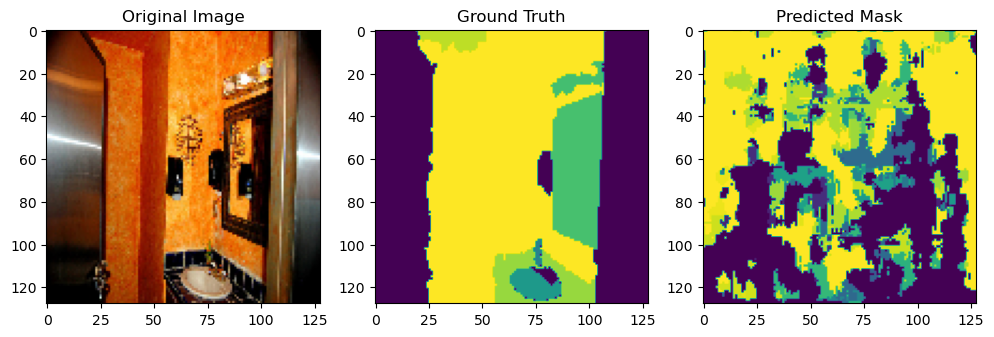

In [34]:
test_idx = random.randint(0, len(val_dataset) - 1)
visualize_predictions(model.to(device1), val_dataset, device1, idx=test_idx)